In [1]:
import pandas as pd
import sys
import argparse
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
import glob
import traceback
import re
from pathlib import Path

In [73]:
#Merge events files 
all_events_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2"
all_events_files = glob.glob(os.path.join(all_events_path, "*_events.csv"))
all_events_df = pd.DataFrame()

# Use folder name to create file label: 
folder_main   = Path(all_events_path).name 
parts = folder_main.split('_')
if parts and re.fullmatch(r"\d{8}", parts[0]):
    run_label = "_".join(parts[1:])       # "SHF01_Session1"
else:
    run_label = folder_main              # use full folder name
n_files = len(all_events_files)
print(f"Found {n_files} event files to merge for run: {run_label}")

dfs = []
for file in all_events_files:
    try:
        # Read EVERYTHING as string so nothing gets rounded
        temp_df = pd.read_csv(file, sep="\t", dtype=str)

        # Convert only safe integer columns (edit names if yours differ)
        for c in ["trial", "button_index"]:
            if c in temp_df.columns:
                temp_df[c] = pd.to_numeric(temp_df[c], errors="coerce").astype("Int64")

        # IMPORTANT: keep ros_time as string to preserve decimals exactly
        # temp_df["ros_time"] stays dtype=str

        dfs.append(temp_df)

    except Exception as e:
        print(f"Error reading {file}: {e}")
        traceback.print_exc()

all_events_df = pd.concat(dfs, ignore_index=True)

out_name = f"{run_label}_combined_events.csv"
out_path = os.path.join(all_events_path, out_name)

all_events_df.to_csv(out_path, index=False, sep="\t")
print("Saved:", out_path)

# sanity check: show raw characters (should include '.')
if "ros_time" in all_events_df.columns:
    print("Example ros_time values:", all_events_df["ros_time"].head(5).tolist())


Found 2 event files to merge for run: SNHF08_Session2
Saved: D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2\SNHF08_Session2_combined_events.csv


In [ ]:
# Function to read trial comments related to success/failure/collision
def read_trial_comments(session_dir: Path, trial_is_one_based=True, collision_run_label=None):
    """
    Reads files like:
      SNHF06_Session1_000_commnet   (or .txt)
    Content like:
      good 3

    Returns DataFrame with: session, trial, comment_label, comment_value
    """
    session_dir = Path(session_dir)
    collision_run_label = str(collision_run_label)
    m_fallback = re.search(r"Session(?P<session>\d+)", collision_run_label, re.IGNORECASE)
    fallback_session = int(m_fallback.group("session")) if m_fallback else pd.NA

    # accept both "commnet" and "comment", with or without extension
    rx = re.compile(
    r".*(?:_Session(?P<session>\d+))?_(?P<idx>\d{3})_(?:commnet|comment)(?:\.\w+)?$",
        re.IGNORECASE
    )

    rows = []
    for p in sorted(session_dir.glob("*_commnet*")) + sorted(session_dir.glob("*_comment*")):
        m = rx.match(p.name)
        if not m:
            continue

        session_str = m.group("session")
        session = int(session_str) if session_str is not None else fallback_session
        idx = int(m.group("idx"))                 # 000, 001, ...
        trial = idx if trial_is_one_based else idx

        text = p.read_text(encoding="utf-8", errors="ignore").strip()
        parts = text.split()

        label = parts[0] if len(parts) >= 1 else pd.NA
        value = parts[1] if len(parts) >= 2 else pd.NA

        # numeric if possible
        try:
            value = float(value)
        except Exception:
            pass

        rows.append({
            "session": session,
            "trial": trial,
            "comment_label": label,
            "comment_value": value,
        })

    df = pd.DataFrame(rows).sort_values(["session", "trial"], na_position="last")
    return df


# --- usage ---
SESSION_DIR = Path(r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251210_SHF04_Session2")

collision_run_label = SESSION_DIR.name  # or str(SESSION_DIR) also works


comments_df = read_trial_comments(SESSION_DIR, trial_is_one_based=True, collision_run_label = collision_run_label)
print(comments_df)
col_out_path = SESSION_DIR / "SHF04_Session1_collisions.csv"
comments_df.to_csv(col_out_path, index=False)


    session  trial comment_label  comment_value
0         1      0          good            1.0
1         1      1          good            0.0
2         1      2          good            0.0
3         1      3          good            0.0
4         1      4          good            1.0
5         1      5          good            2.0
6         1      6          good            0.0
7         1      7          good            0.0
8         1      8          good            1.0
9         1      9          good            0.0
10        1     10          good            0.0
11        1     11          good            0.0
12        1     12          good            0.0
13        1     13          good            0.0
14        1     14          good            0.0
15        1     15          good            0.0
16        1     16          good            0.0
17        1     17          good            0.0
18        1     18          good            0.0
19        1     19          good        

In [80]:
# Trial events time stamps: using collision file to segment 
all_events_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2"
folder = Path(all_events_path).name

m = re.search(r"_(?P<pid>[A-Za-z]+[0-9]+)_Session(?P<session>\d+)", folder, re.IGNORECASE)
if not m:
    raise ValueError(f"Could not parse pid/session from folder name: {folder}")

pid = m.group("pid")
session = int(m.group("session"))


events_file = glob.glob(os.path.join(all_events_path, "*_combined_events.csv"))
collision_files = glob.glob(os.path.join(all_events_path, f"{pid}_Session{session}_collisions.csv"))
print(collision_files)

if events_file and os.path.isfile(events_file[0]):
    print("Found:", events_file[0])
else:
    print("Not found:", events_file)
    events_file = glob.glob(os.path.join(all_events_path, "*_events.csv"))

collision_df = pd.read_csv(collision_files[0])
events_df = pd.read_csv(events_file[0])   

def trial_timestamps_from_events_with_fail_trials(
    events_df: pd.DataFrame,
    collision_df: pd.DataFrame,
    trial_col: str = "trial",
    event_col: str = "event",
    time_col: str = "ros_time",
    comment_col: str = "comment_label",
    fail_value: str = "fail",
):
    if comment_col in collision_df.columns:
        fail_mask = (
            collision_df[comment_col]
            .astype(str)
            .str.strip()
            .str.lower()
            .eq(str(fail_value).lower())
        )
        fail_trials = set(collision_df.loc[fail_mask, trial_col].dropna().tolist())
    else:
        fail_trials = set()
    out = []

    # iterate trials based on events_df order
    for trial, g in events_df.groupby(trial_col, sort=False):
        # If fail -> only save trial + fail
        if trial in fail_trials:
            out.append({trial_col: trial, "outcome": "fail"})
            continue

        g = g.sort_values(time_col)

        share_times = g.loc[g[event_col] == "share_button", time_col]
        rec_times   = g.loc[g[event_col] == "start_recording", time_col]
        sq_times    = g.loc[g[event_col] == "square_button", time_col]

        # start: prefer share_button, else start_recording
        if len(share_times) > 0:
            start_time = share_times.iloc[0]
        elif len(rec_times) > 0:
            start_time = rec_times.iloc[0]
        else:
            start_time = pd.NA

        # end: take LAST square_button after start_time (fallback: last square_button)
        if len(sq_times) == 0:
            end_time = pd.NA
        else:
            if pd.isna(start_time):
                end_time = sq_times.iloc[-1]
            else:
                after = sq_times[sq_times >= start_time]
                end_time = after.iloc[-1] if len(after) > 0 else sq_times.iloc[-1]

        out.append({trial_col: trial, "outcome": "ok", "start_time": start_time, "end_time": end_time})

    return pd.DataFrame(out)

trial_ts = trial_timestamps_from_events_with_fail_trials(
    events_df=events_df,
    collision_df=collision_df,
    trial_col="trial",
    event_col="event",
    time_col="ros_time",
    comment_col="comment_label",
    fail_value="fail"
)
out_dir = Path(all_events_path) 
out_dir.mkdir(parents=True, exist_ok=True)

# --- build a nice filename ---
out_csv = out_dir / f"{pid}_Session{session}_trial_timestamps.csv"

# --- save ---
trial_ts.to_csv(out_csv, index=False)



['D:\\Box Sync\\Box Sync\\00_BEAR_Lab\\Projects\\Kyler(Kihun) Hong\\1st_Haptic Sleeve\\PilotExperiment\\MotorLearning\\20251230_SNHF08_Session2\\SNHF08_Session2_collisions.csv']
Found: D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2\SNHF08_Session2_combined_events.csv


In [81]:
# Data segmentation
ROOT1 = Path(r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2\Rosbag")
Rosfolder = ROOT1.parent.name
print(Rosfolder)
m = re.search(r"_(?P<pid>[A-Za-z]+[0-9]+)_Session(?P<session>\d+)", Rosfolder, re.IGNORECASE)
if not m:
    raise ValueError(f"Could not parse pid/session from folder name: {Rosfolder}")
pid = m.group("pid") 
print(pid[-1])
session = int(m.group("session"))
collision_files = glob.glob(os.path.join(all_events_path, f"{pid}_Session{session}_collisions.csv"))
TF_GLOB = f"SNHF0{pid[-1]}_Session{session}_*_tf"             # matches 000_tf, 001_tf, ...
TOPIC_SUBSTRINGS = [
    "vx300s-commands-joy_processed",
    "vx300s-gripper_pos",
    "vx300s-gripper_vel"   # common spelling (in case)
]

TRIAL_IS_ONE_BASED = True

def pick_time_col(df: pd.DataFrame):
    """Try common time columns from bag conversions."""
    candidates = [
        "Time"
    ]
    for c in candidates:
        if c in df.columns:
            return c
    # last resort: any column containing 'time' or 'stamp'
    for c in df.columns:
        lc = c.lower()
        if "time" in lc or "stamp" in lc:
            return c
    raise ValueError(f"No time column found. Columns={list(df.columns)[:30]}...")

def find_topic_csvs(trial_folder: Path):
    """Return {substring: [csv_paths...]} for the substrings we care about."""
    csvs = list(trial_folder.glob("*.csv"))
    hits = {}
    for sub in TOPIC_SUBSTRINGS:
        matches = [p for p in csvs if sub in p.name]
        if matches:
            hits[sub] = matches
    return hits


def folder_index_from_name(folder: Path):
    # expects ..._000_tf
    m = re.search(r"_(\d{3})_tf$", folder.name)
    if not m:
        return None
    return int(m.group(1))

def segment_csv(in_path: Path, out_path: Path, start_time, end_time):
    df = pd.read_csv(in_path)
    tcol = pick_time_col(df)

    # Ensure numeric
    df[tcol] = pd.to_numeric(df[tcol], errors="coerce")

    seg = df[(df[tcol] >= start_time) & (df[tcol] <= end_time)].copy()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    seg.to_csv(out_path, index=False)
    return len(seg), tcol

def segment_all_trials (ts: pd.DataFrame, root: Path): 
    trial_folders = sorted(root.glob(TF_GLOB))
    print(f"Found {len(trial_folders)} trial folders to segment."   )
    for folder in trial_folders:
        idx = folder_index_from_name(folder)
        if idx is None:
            print(f"Skipping folder with unexpected name: {folder}")
            continue
        trial_num = idx  if TRIAL_IS_ONE_BASED else idx
        row = ts.loc[ts['trial'] == trial_num]
        if row.empty: 
            print(f"No timestamp data for trial {trial_num}, skipping folder {folder}")
            continue
        start_time = row['start_time'].values[0]
        end_time = row['end_time'].values[0]    
        
        if pd.isna(start_time) or pd.isna(end_time):
            print(f"[WARN] Missing start/end for trial={trial_num} -> start={start_time}, end={end_time}")
            continue
        hits = find_topic_csvs(folder)
        if not hits:
            print(f"[WARN] No matching topic CSVs found in {folder.name}")
            continue

        out_dir = folder / "segmented"
        print(f"\nTrial {trial_num} ({folder.name}) start={start_time} end={end_time}")

        for sub, paths in hits.items():
            for p in paths:
                out_path = out_dir / p.name.replace(".csv", "_seg.csv")
                n, tcol = segment_csv(p, out_path, start_time, end_time)
                print(f"  - {p.name}  -> {out_path.name}  rows={n}  (time_col={tcol})")


segment_all_trials(trial_ts, ROOT1)

20251230_SNHF08_Session2
8
Found 44 trial folders to segment.
[WARN] Missing start/end for trial=0 -> start=nan, end=nan

Trial 1 (SNHF08_Session2_001_tf) start=1767120186.602203 end=1767120248.426207
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=6530  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=618  (time_col=Time)
  - vx300s-gripper_vel.csv  -> vx300s-gripper_vel_seg.csv  rows=618  (time_col=Time)

Trial 2 (SNHF08_Session2_002_tf) start=1767120262.910259 end=1767120316.002061
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  rows=4919  (time_col=Time)
  - vx300s-gripper_pos.csv  -> vx300s-gripper_pos_seg.csv  rows=531  (time_col=Time)
  - vx300s-gripper_vel.csv  -> vx300s-gripper_vel_seg.csv  rows=531  (time_col=Time)

Trial 3 (SNHF08_Session2_003_tf) start=1767120330.4021037 end=1767120380.5942695
  - vx300s-commands-joy_processed.csv  -> vx300s-commands-joy_processed_seg.csv  

In [82]:

def trial_from_path_tf_folder(p: Path):
    """
    Extract trial number from a parent folder like:
      SNHF06_Session1_001_tf
    Returns int or None.
    """
    p = Path(p)
    for parent in [p.parent] + list(p.parents):
        m = re.search(r"_(\d{3})_tf$", parent.name)
        if m:
            return int(m.group(1))
    return None

def group_lims(X, labelmode=False):
    X = np.asarray(X).ravel()
    if X.size == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=int)

    if labelmode:
        G = X.astype(int)
        dG = np.diff(G)

        lidx_starts = np.r_[G[0] != 0, dG > 0]
        idx_starts = np.flatnonzero(lidx_starts)

        lidx_stops = np.r_[((lidx_starts[1:] & (G[:-1] > 0)) | (dG < 0)), G[-1] != 0]
        idx_stops = np.flatnonzero(lidx_stops)
    else:
        transitions = np.diff(X) != 0
        idx_starts = np.flatnonzero(np.r_[True, transitions])
        idx_stops  = np.flatnonzero(np.r_[transitions, True])

    lengths = idx_stops + 1 - idx_starts
    return idx_starts, idx_stops, lengths


def moving_idle_metrics_from_segment(v, t, vel_threshold=0.02, completion_time=None):
    v = np.asarray(v, dtype=float).ravel()
    t = np.asarray(t, dtype=float).ravel()

    if len(v) == 0 or len(t) == 0:
        return {
            "completion_time": np.nan,
            "activation_percent": np.nan,
            "longest_moving_time": np.nan,
            "longest_moving_percent": np.nan,
            "longest_idle_time": np.nan,
            "longest_idle_percent": np.nan,
        }

    if completion_time is None:
        completion_time = float(t[-1] - t[0])
    if completion_time <= 0:
        completion_time = np.nan

    vel_threshold_idx = np.flatnonzero(v > vel_threshold)

    moving = np.zeros_like(v, dtype=int)
    moving[vel_threshold_idx] = 1
    idle = 1 - moving

    # Longest moving bout
    mv_s, mv_e, mv_len = group_lims(moving, labelmode=True)
    if mv_len.size:
        k = int(np.argmax(mv_len))
        longest_moving_time = float(t[mv_e[k]] - t[mv_s[k]])
    else:
        longest_moving_time = 0.0

    # Longest idle bout
    id_s, id_e, id_len = group_lims(idle, labelmode=True)
    if id_len.size:
        k = int(np.argmax(id_len))
        longest_idle_time = float(t[id_e[k]] - t[id_s[k]])
    else:
        longest_idle_time = 0.0

    activation_percent = 100.0 * (len(vel_threshold_idx) / len(v)) if len(v) else np.nan
    longest_moving_percent = (100.0 * longest_moving_time / completion_time) if np.isfinite(completion_time) else np.nan
    longest_idle_percent   = (100.0 * longest_idle_time   / completion_time) if np.isfinite(completion_time) else np.nan

    return {
        "completion_time": completion_time,
        "activation_percent": activation_percent,
        "longest_moving_time": longest_moving_time,
        "longest_moving_percent": longest_moving_percent,
        "longest_idle_time": longest_idle_time,
        "longest_idle_percent": longest_idle_percent,
    }


def compute_metrics_from_segmented_csv_using_events_time(
    seg_csv_path,
    ts_df,    
    trial_col="trial",            # <-- add this
# must contain columns: trial, start_time, end_time
    vx_col="twist.linear.x",
    vy_col="twist.linear.y",
    vz_col="twist.linear.z",
    vel_threshold=0.02,
    use_speed_magnitude=True,
    time_col = None, 
    time_candidates = "Time",
    crop_to_events = True,
):
    seg_csv_path = Path(seg_csv_path)

    trial = trial_from_path_tf_folder(seg_csv_path)
    if trial is None:
        return {"trial": pd.NA, "source_file": str(seg_csv_path), "note": "trial not found from *_###_tf folder"}

    # lookup events-based start/end
    r = ts_df.loc[ts_df[trial_col] == trial]
    if r.empty:
        return {"trial": trial, "source_file": str(seg_csv_path), "note": "trial not found in ts_df"}

    start_time = float(r["start_time"].iloc[0])
    end_time   = float(r["end_time"].iloc[0])
    if not np.isfinite(start_time) or not np.isfinite(end_time) or end_time <= start_time:
        return {"trial": trial, "source_file": str(seg_csv_path), "note": "bad start/end in ts_df"}

    completion_time = end_time - start_time

    df = pd.read_csv(seg_csv_path)
    
    # --- choose time column ---
    if time_col is None:
        for c in time_candidates:
            if c in df.columns:
                time_col = c
                break
    if time_col is None or time_col not in df.columns:
        return {
            "trial": trial,
            "source_file": str(seg_csv_path),
            "note": f"time column not found (tried: {time_candidates})"
        }
        
    # build 1D speed (NO time column used)
    t_raw = pd.to_numeric(df[time_col], errors="coerce").to_numpy(float)
    t = t_raw

    vx = pd.to_numeric(df[vx_col], errors="coerce").to_numpy(float)

    if use_speed_magnitude:
        vy = pd.to_numeric(df[vy_col], errors="coerce").to_numpy(float)
        vz = pd.to_numeric(df[vz_col], errors="coerce").to_numpy(float)
        v = np.sqrt(vx*vx + vy*vy + vz*vz)
    else:
        v = vx

    # --- keep alignment between t and v ---
    m = np.isfinite(t) & np.isfinite(v)
    t = t[m]
    v = v[m]

    if t.size < 2:
        return {"trial": trial, "source_file": str(seg_csv_path), "note": "too few valid samples", "n_samples": int(t.size)}

    # --- optionally crop to the event window ---
    if crop_to_events:
        w = (t >= start_time) & (t <= end_time)
        t = t[w]
        v = v[w]
        if t.size < 2:
            return {"trial": trial, "source_file": str(seg_csv_path), "note": "no/too few samples within event window", "n_samples": int(t.size)}

    # (optional but recommended) ensure monotonic time
    order = np.argsort(t)
    t = t[order]
    v = v[order]

    # IMPORTANT: use completion_time from ts_df for percent metrics,
    # but use seg-csv time axis 't' for bout durations.
    metrics = moving_idle_metrics_from_segment(v, t, vel_threshold=vel_threshold, completion_time=completion_time)
    metrics.update({
        "trial": trial,
        "start_time": start_time,
        "end_time": end_time,
        "n_samples": int(t.size),
        "source_file": str(seg_csv_path),
        "time_col_used": time_col,
        "note": ""
    })
    return metrics


In [83]:
# smoothness 
def spectral_arc_length(speed, Ts=1/10, parameters=(0.05, 10.0, 4)):
    """
    Compute movement smoothness using the Spectral Arc Length (SAL) method.

    Parameters
    ----------
    speed : array-like
        1D speed profile (assumed already filtered + segmented).
    Ts : float, optional
        Sampling time in seconds. Default: 1/100 (i.e., 100 Hz).
    parameters : tuple/list of length 3, optional
        (amp_thresh, fc_max_hz, zero_pad_idx)
        - amp_thresh: amplitude threshold for choosing cutoff frequency (default 0.05)
        - fc_max_hz: maximum cutoff frequency in Hz (default 10.0)
        - zero_pad_idx: zero padding index controlling spectrum resolution (default 4)

    Returns
    -------
    S : float
        Spectral arc length smoothness (negative; larger magnitude => less smooth).
    """
    # --- input checks ---
    speed = np.asarray(speed, dtype=float).squeeze()

    if speed.ndim != 1 or speed.size <= 1:
        raise ValueError("speed must be a 1D array with length > 1.")
    if not np.isscalar(Ts):
        raise ValueError("Ts must be a scalar.")
    if len(parameters) != 3:
        raise ValueError("parameters must have length 3: (amp_thresh, fc_max_hz, zero_pad_idx).")

    amp_thresh, fc_max_hz, zero_pad_idx = parameters

    N = speed.size
    # MATLAB: Nfft = 2^(ceil(log2(N)) + zero_pad_idx)
    exp = int(np.ceil(np.log2(N)))
    Nfft = 2 ** (exp + int(zero_pad_idx))

    # --- spectrum ---
    speed_spectrum = np.abs(np.fft.fft(speed, n=Nfft))
    max_val = np.max(speed_spectrum)
    if max_val == 0:
        # no signal energy -> undefined smoothness
        return np.nan

    speed_spectrum = speed_spectrum / max_val

    # MATLAB: freq = 0:(1/Ts)*(1/Nfft):(1/Ts)*((Nfft-1)/Nfft)
    freq = np.arange(Nfft) * (1.0 / Ts) / Nfft

    # last index where freq <= fc_max_hz AND spectrum >= amp_thresh
    mask = (freq <= fc_max_hz) & (speed_spectrum >= amp_thresh)
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        # fallback: use at least the first two points to avoid division by zero
        inxFc = min(1, Nfft - 1)
    else:
        inxFc = int(idxs[-1])

    # MATLAB: speedSpectrum = speedSpectrum(1:inxFc); (1-based inclusive)
    # Python: include index inxFc => slice [:inxFc+1]
    spec = speed_spectrum[:inxFc + 1]
    M = spec.size
    if M < 2:
        return np.nan

    # MATLAB: dArcLengths = sqrt((1/(inxFc-1))^2 + (diff(spec)).^2)
    # Here M == inxFc+1, so use (1/(M-1)) like MATLAB intended for the selected vector length.
    d_arc = np.sqrt((1.0 / (M - 1))**2 + np.diff(spec)**2)

    # MATLAB: S = -sum(dArcLengths)
    S = -float(np.sum(d_arc))
    return S


In [84]:
#All sessions 
all_events_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2"
SEG_DIR = Path(r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2\Rosbag")

folder = Path(all_events_path).name

m = re.search(r"_(?P<pid>[A-Za-z]+[0-9]+)_Session(?P<session>\d+)", folder, re.IGNORECASE)
if not m:
    raise ValueError(f"Could not parse pid/session from folder name: {folder}")

pid = m.group("pid")
session = int(m.group("session"))


events_file = glob.glob(os.path.join(all_events_path, "*_combined_events.csv"))
collision_files = glob.glob(os.path.join(all_events_path, f"{pid}_Session{session}_collisions.csv"))

if events_file and os.path.isfile(events_file[0]):
    print("Found:", events_file[0])
else:
    print("Not found:", events_file)
    events_file = glob.glob(os.path.join(all_events_path, "*_events.csv"))
print(events_file[0])
print(collision_files)
collision_df = pd.read_csv(collision_files[0])
events_df = pd.read_csv(events_file[0])   

seg_files = sorted(SEG_DIR.glob("**/*vx300s-gripper_vel_seg*.csv"))
df0 = pd.read_csv(seg_files[0])

trial_ts = trial_timestamps_from_events_with_fail_trials(
    events_df=events_df,
    collision_df=collision_df,
    trial_col="trial",
    event_col="event",
    time_col="ros_time",
    comment_col="comment_label",
    fail_value="fail"
)
 
trial_ts["trial"] = pd.to_numeric(trial_ts["trial"], errors="coerce")
trial_ts["start_time"] = pd.to_numeric(trial_ts["start_time"], errors="coerce")
trial_ts["end_time"]   = pd.to_numeric(trial_ts["end_time"], errors="coerce")

# 2) compute metrics from segmented files, BUT using events timing

rows = []
for f in seg_files:
    rows.append(compute_metrics_from_segmented_csv_using_events_time(
        f,
        ts_df=trial_ts,
        trial_col="trial",
        time_col = "Time",
        vel_threshold=0.02,
        use_speed_magnitude=True,
    ))

all_trials_df = (
    trial_ts[["trial"]]
    .dropna()
    .drop_duplicates()
    .sort_values("trial")
    .reset_index(drop=True)
)
trial_metrics = pd.DataFrame(rows)

# left-join metrics onto full trial list; missing trials get NaN metrics
trial_metrics = all_trials_df.merge(trial_metrics, on="trial", how="left")

# optional: mark missing seg trials
trial_metrics["source_file"] = trial_metrics.get("source_file", pd.Series(dtype="object")).fillna("")

# sort nicely
trial_metrics = trial_metrics.sort_values("trial").reset_index(drop=True)

print(trial_metrics[[
    "trial", "completion_time", "activation_percent",
    "longest_moving_time", "longest_moving_percent",
    "longest_idle_time", "longest_idle_percent",
    "n_samples"
]].to_string(index=False))

Found: D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2\SNHF08_Session2_combined_events.csv
D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2\SNHF08_Session2_combined_events.csv
['D:\\Box Sync\\Box Sync\\00_BEAR_Lab\\Projects\\Kyler(Kihun) Hong\\1st_Haptic Sleeve\\PilotExperiment\\MotorLearning\\20251230_SNHF08_Session2\\SNHF08_Session2_collisions.csv']
 trial  completion_time  activation_percent  longest_moving_time  longest_moving_percent  longest_idle_time  longest_idle_percent  n_samples
     0              NaN                 NaN                  NaN                     NaN                NaN                   NaN        NaN
     1        61.824004           60.517799             8.799996               14.233946           1.999981              3.234959      618.0
     2        53.091802           64.030132           

In [85]:
def smoothness_from_segmented_csv(
    seg_csv_path,
    ts_df,
    trial_col="trial",
    time_col="Time",
    vx_col="twist.linear.x",
    vy_col="twist.linear.y",
    vz_col="twist.linear.z",
    use_speed_magnitude=True,
    crop_to_events=True,
    Ts=0.1,  # <- you said you want to use fixed Ts, no estimation
    parameters=(0.05, 5.0, 4),  # (amp_thresh, fc_max_hz, zero_pad_idx)
):
    seg_csv_path = Path(seg_csv_path)

    trial = trial_from_path_tf_folder(seg_csv_path)
    if trial is None:
        return {"trial": pd.NA, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": "trial not found"}

    # lookup events-based start/end
    r = ts_df.loc[ts_df[trial_col] == trial]
    if r.empty:
        return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": "trial not found in ts_df"}

    start_time = float(r["start_time"].iloc[0])
    end_time   = float(r["end_time"].iloc[0])
    if not np.isfinite(start_time) or not np.isfinite(end_time) or end_time <= start_time:
        return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": "bad start/end in ts_df"}

    df = pd.read_csv(seg_csv_path)

    if time_col not in df.columns:
        return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": f"missing time col: {time_col}"}
    if vx_col not in df.columns:
        return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": f"missing vx col: {vx_col}"}

    t = pd.to_numeric(df[time_col], errors="coerce").to_numpy(float)

    vx = pd.to_numeric(df[vx_col], errors="coerce").to_numpy(float)
    if use_speed_magnitude:
        if (vy_col not in df.columns) or (vz_col not in df.columns):
            return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path),
                    "note": f"missing vy/vz cols: {vy_col}, {vz_col}"}
        vy = pd.to_numeric(df[vy_col], errors="coerce").to_numpy(float)
        vz = pd.to_numeric(df[vz_col], errors="coerce").to_numpy(float)
        v = np.sqrt(vx*vx + vy*vy + vz*vz)
    else:
        v = vx

    # align and clean
    m = np.isfinite(t) & np.isfinite(v)
    t = t[m]
    v = v[m]

    if t.size < 2:
        return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": "too few valid samples"}

    if crop_to_events:
        w = (t >= start_time) & (t <= end_time)
        t = t[w]
        v = v[w]
        if t.size < 2:
            return {"trial": trial, "smoothness": np.nan, "source_file": str(seg_csv_path), "note": "too few samples in window"}

    # SAL expects a speed profile (1D)
    S = spectral_arc_length(v, Ts=Ts, parameters=parameters)

    return {"trial": trial, "smoothness": S, "source_file": str(seg_csv_path), "note": ""}

# compute smoothness for all segmented vel files
smooth_rows = []
for f in seg_files:
    smooth_rows.append(smoothness_from_segmented_csv(
        f,
        ts_df=trial_ts,
        trial_col="trial",
        time_col="Time",
        use_speed_magnitude=True,
        crop_to_events=True,
        Ts=0.1,                       # fixed 0.1s sample time
        parameters=(0.05, 5.0, 4)      # you chose 5Hz because Fs=10Hz -> Nyquist=5Hz
    ))

smooth_df = pd.DataFrame(smooth_rows)

# ---- SAME FIX: keep ALL trials even if no seg file exists ----
all_trials_df = (
    trial_ts[["trial"]]
    .dropna()
    .drop_duplicates()
    .sort_values("trial")
    .reset_index(drop=True)
)

smooth_df = all_trials_df.merge(smooth_df, on="trial", how="left")

# keep only what you want
smooth_df = smooth_df[["trial", "smoothness"]].sort_values("trial").reset_index(drop=True)
print(smooth_df)





    trial  smoothness
0       0         NaN
1       1   -5.576908
2       2   -3.901423
3       3   -5.126071
4       4   -3.616051
5       5   -5.654855
6       6   -3.344780
7       7   -3.503698
8       8   -4.556283
9       9   -3.440836
10     10         NaN
11     11   -3.535781
12     12   -3.716248
13     13   -3.774037
14     14   -3.217993
15     15   -3.467377
16     16   -3.675569
17     17   -3.948093
18     18   -4.140797
19     19   -5.842959
20     20   -3.512592
21     21   -3.384581
22     22   -3.677332
23     23   -3.177461
24     24   -3.972671
25     25   -4.061341
26     26   -4.434260
27     27   -3.223982
28     28   -3.782766
29     29         NaN
30     30   -8.498936
31     31   -6.862292
32     32   -4.530045
33     33   -3.158834
34     34   -3.495802
35     35   -2.958173
36     36   -3.531936
37     37   -5.652604
38     38   -6.619130
39     39   -3.471242
40     40   -3.248993
41     41   -5.083212
42     42   -3.588406
43     43   -2.915171


In [86]:
#Merge two dataframes 

trial_metrics["trial"] = pd.to_numeric(trial_metrics["trial"], errors="coerce")
smooth_df["trial"]     = pd.to_numeric(smooth_df["trial"], errors="coerce")

smooth_df_ren = smooth_df.rename(columns={
    "source_file": "smooth_source_file",
    "note": "smooth_note"
})

merged = trial_metrics.merge(
    smooth_df[["trial", "smoothness"]],
    on="trial",
    how="left"
)

# --- keep only what you want (NO n_samples / note / smooth_note) ---
out_df = merged[[
    "trial",
    "completion_time", "activation_percent",
    "longest_moving_time", "longest_moving_percent",
    "longest_idle_time", "longest_idle_percent",
    "smoothness",
]].sort_values("trial", na_position="last")

out_df.insert(0, "session", session)  # put session as the first column
out_df = out_df.sort_values(["session", "trial"], na_position="last")

# --- save into the folder ---
OUT_DIR = Path(all_events_path)
OUT_DIR.mkdir(parents=True, exist_ok=True)

metric_csv = OUT_DIR / f"{pid}_Session{session}_trialmetrics.csv"
out_df.to_csv(metric_csv, index=False)

print(out_df)

    session  trial  completion_time  activation_percent  longest_moving_time  \
0         2      0              NaN                 NaN                  NaN   
1         2      1        61.824004           60.517799             8.799996   
2         2      2        53.091802           64.030132             9.600033   
3         2      3        50.192166           63.545817            10.299851   
4         2      4        56.543817           73.805310            11.399990   
5         2      5        58.403994           65.582192            10.600015   
6         2      6        39.996112           72.500000            12.100001   
7         2      7        39.708095           72.292191            11.099995   
8         2      8        49.884034           72.144289            10.100094   
9         2      9        41.696238           76.019185            12.300068   
10        2     10              NaN                 NaN                  NaN   
11        2     11        39.128231     

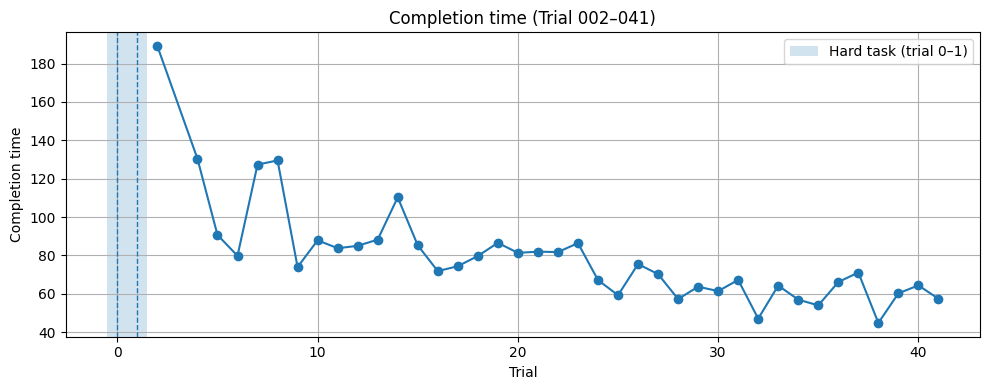

In [35]:
trial_metrics["trial"] = pd.to_numeric(trial_metrics["trial"], errors="coerce")
trial_metrics["start_time"] = pd.to_numeric(trial_metrics["start_time"], errors="coerce")
trial_ts["end_time"]   = pd.to_numeric(trial_ts["end_time"], errors="coerce")

# 2) compute completion time (seconds, if your ros_time is in seconds)
trial_ts["completion_time"] = trial_ts["end_time"] - trial_ts["start_time"]

# 3) filter trials 002~041  -> 2~41
ts_2_41 = trial_metrics[(trial_metrics["trial"] >= 2) & (trial_metrics["trial"] <= 41)].copy()
ts_2_41 = ts_2_41.dropna(subset=["completion_time"]).sort_values("trial")

# optional: save
# ts_2_41.to_csv("completion_time_trial002_041.csv", index=False)

# 4) plot
fig, ax = plt.subplots(figsize=(10,4))

ax.axvspan(-0.5, 1.5, alpha=0.2, label="Hard task (trial 0–1)")

ax.plot(ts_2_41["trial"], ts_2_41["completion_time"], marker="o")
ax.set_xlabel("Trial")
ax.set_ylabel("Completion time")
ax.set_title("Completion time (Trial 002–041)")
ax.grid(True)
ax.axvline(0, linestyle="--", linewidth=1)
ax.axvline(1, linestyle="--", linewidth=1)
ax.legend()
plt.tight_layout()
plt.show()


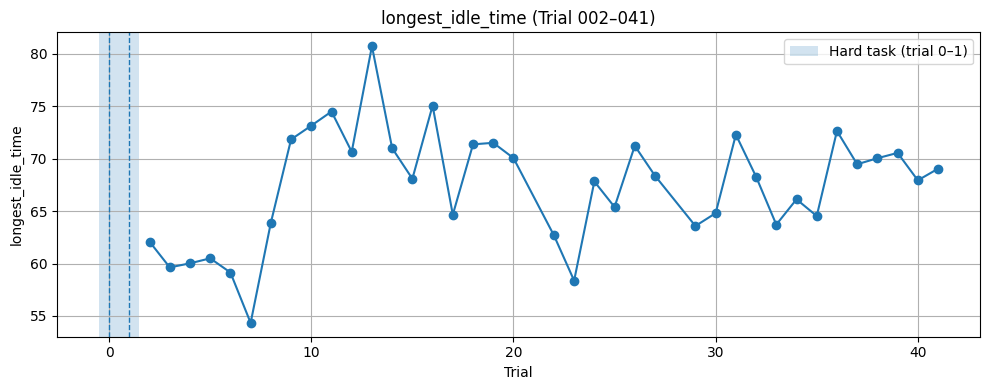

In [9]:
# 4) plot activation percent
trial_metrics = pd.DataFrame(rows).sort_values("trial", na_position="last")
trial_metrics_2_41 = trial_metrics[(trial_metrics["trial"] >= 2) & (trial_metrics["trial"] <= 41)].copy()
trial_metrics_2_41 = trial_metrics_2_41.dropna(subset=["activation_percent"]).sort_values("trial")
fig, ax = plt.subplots(figsize=(10,4))

ax.axvspan(-0.5, 1.5, alpha=0.2, label="Hard task (trial 0–1)")

ax.plot(trial_metrics_2_41["trial"], trial_metrics_2_41["activation_percent"], marker="o")
ax.set_xlabel("Trial")
ax.set_ylabel("longest_idle_time")
ax.set_title("longest_idle_time (Trial 002–041)")
ax.grid(True)
ax.axvline(0, linestyle="--", linewidth=1)
ax.axvline(1, linestyle="--", linewidth=1)
ax.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows to plot: 28
unique trials: 28
missing trials: [21, 28, 30]
duplicates: Series([], Name: trial, dtype: int64)


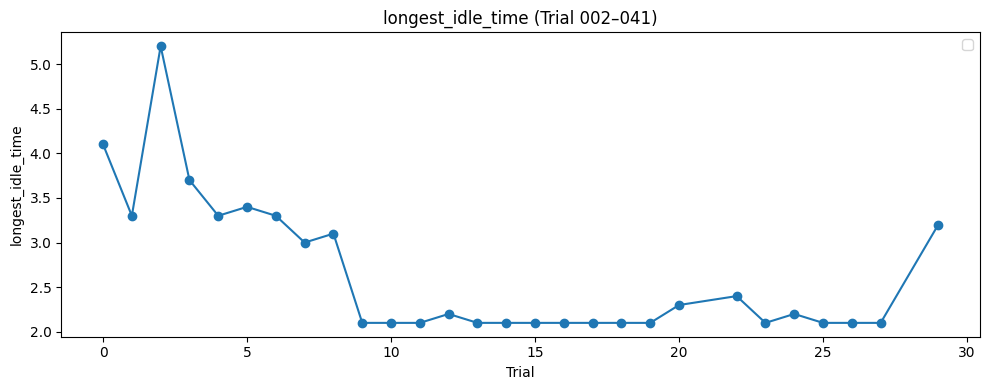

In [ ]:
# 4) plot longest_idle_time
trial_metrics2 = pd.DataFrame(rows).sort_values("trial", na_position="last")
trial_metrics2_2_41 = trial_metrics2[(trial_metrics2["trial"] >= 0) & (trial_metrics2["trial"] <= 29)].copy()
trial_metrics2_2_41 = trial_metrics2_2_41.dropna(subset=["longest_idle_time"]).sort_values("trial")
print("rows to plot:", len(trial_metrics2_2_41))
print("unique trials:", trial_metrics2_2_41["trial"].nunique())
print("missing trials:", sorted(set(range(0,31)) - set(trial_metrics2_2_41["trial"].astype(int))))
print("duplicates:", trial_metrics2_2_41["trial"].value_counts().loc[lambda s: s>1])

fig, ax = plt.subplots(figsize=(10,4))

# ax.axvspan(-0.5, 1.5, alpha=0.2, label="Hard task (trial 0–1)")

ax.plot(trial_metrics2_2_41["trial"], trial_metrics2_2_41["longest_idle_time"], marker="o")
ax.set_xlabel("Trial")
ax.set_ylabel("longest_idle_time")
ax.set_title("longest_idle_time (Trial 002–041)")
ax.legend()
plt.tight_layout()
plt.show()


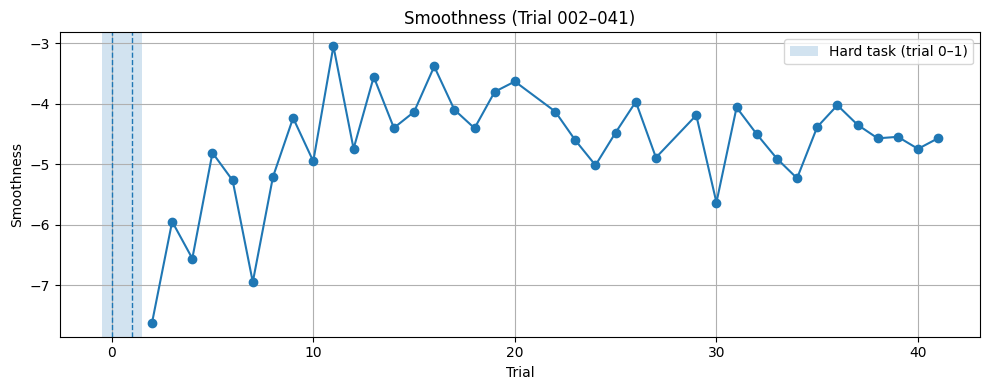

In [11]:
smooth_df["trial"] = pd.to_numeric(smooth_df["trial"], errors="coerce")


# 2) compute completion time (seconds, if your ros_time is in seconds)
# 3) filter trials 002~041  -> 2~41
smoothness = smooth_df[(smooth_df["trial"] >= 2) & (smooth_df["trial"] <= 41)].copy()
smoothness = smoothness.dropna(subset=["smoothness"]).sort_values("trial")

# optional: save
# ts_2_41.to_csv("completion_time_trial002_041.csv", index=False)

# 4) plot
fig, ax = plt.subplots(figsize=(10,4))

ax.axvspan(-0.5, 1.5, alpha=0.2, label="Hard task (trial 0–1)")

ax.plot(smoothness["trial"], smoothness["smoothness"], marker="o")
ax.set_xlabel("Trial")
ax.set_ylabel("Smoothness")
ax.set_title("Smoothness (Trial 002–041)")
ax.grid(True)
ax.axvline(0, linestyle="--", linewidth=1)
ax.axvline(1, linestyle="--", linewidth=1)
ax.legend()
plt.tight_layout()
plt.show()


In [44]:
#Session1,2, and 3 merged collision files depending on participant group and session

P1_session1 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251209_SNFH06_Session3"
P2_session1 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251209_SNFH07_Session3"
P3_session1 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20260105_SNHF08_Session3"

all_paths = [P1_session1, P2_session1, P3_session1]

def parse_folder_meta(all_events_path: str):
    folder = Path(all_events_path).name

    # pid/session from "..._SNHF06_Session1"
    m = re.search(r"_(?P<pid>[A-Za-z]+[0-9]+)_Session(?P<session>\d+)", folder, re.IGNORECASE)
    if not m:
        raise ValueError(f"Could not parse pid/session from folder name: {folder}")

    pid = m.group("pid")
    session = int(m.group("session"))

    # optional: date prefix "YYYYMMDD_..."
    date_m = re.match(r"(?P<date>\d{8})_", folder)
    date_str = date_m.group("date") if date_m else None

    return pid, session, date_str, folder

def add_or_overwrite(df, col, value, loc=None):
    """If col exists -> overwrite; else insert at loc (or append)."""
    if col in df.columns:
        df[col] = value
    else:
        if loc is None:
            df[col] = value
        else:
            df.insert(loc, col, value)

all_collision_dfs = []

for p in all_paths:
    pid, session, date_str, folder = parse_folder_meta(p)

    collision_files = glob.glob(os.path.join(p, f"{pid}_Session{session}_collisions.csv"))
    if not collision_files:
        collision_files = glob.glob(os.path.join(p, "*_collisions.csv"))
    if not collision_files:
        print(f"[SKIP] No collision file found in: {p}")
        continue

    cf = collision_files[0]
    df = pd.read_csv(cf)

    # add indicators safely
    add_or_overwrite(df, "pid", pid, loc=0)
    add_or_overwrite(df, "session", session, loc=1)   # will overwrite if already present

    all_collision_dfs.append(df)

collision_all = pd.concat(all_collision_dfs, ignore_index=True)
out_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group\collisions_all_session3.csv"
collision_all.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group\collisions_all_session3.csv


       pid  coll_per_good_trial            window  planned_trials
0   SNFH06             5.750000    First-5\n(2–6)               5
1   SNFH07             0.600000    First-5\n(2–6)               5
2   SNHF08             3.250000    First-5\n(2–6)               5
3   SNFH06             0.888889   Mid-10A\n(7–16)              10
4   SNFH07             0.400000   Mid-10A\n(7–16)              10
5   SNHF08             2.800000   Mid-10A\n(7–16)              10
6   SNFH06             0.800000  Mid-10B\n(17–26)              10
7   SNFH07             0.333333  Mid-10B\n(17–26)              10
8   SNHF08             0.700000  Mid-10B\n(17–26)              10
9   SNFH06             1.600000   Last-5\n(37–41)               5
10  SNFH07             0.400000   Last-5\n(37–41)               5
11  SNHF08             0.600000   Last-5\n(37–41)               5
level_1            window      high       low    median
0          First-5\n(2–6)  4.500000  1.925000  3.250000
1         Mid-10A\n(7–16)  1.8

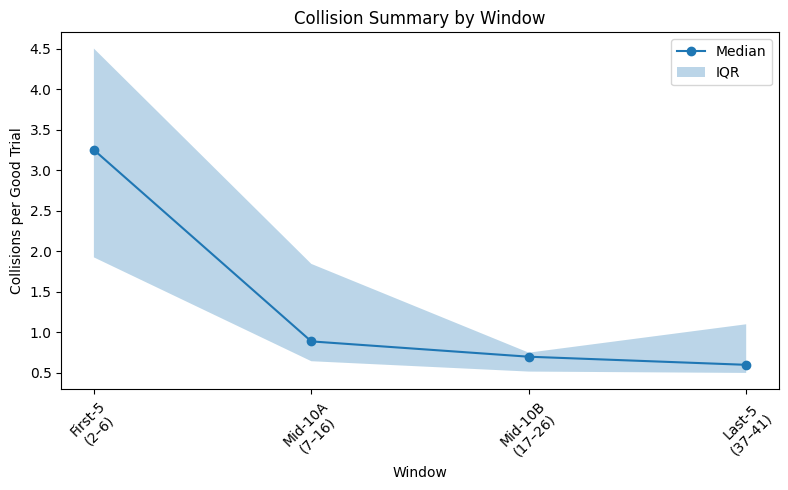

In [49]:

# ====== EDIT THIS ======
IN_PATH = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group\collisions_all_session1.csv"
GOOD_LABEL = "good"
USE_IQR = True   # True = IQR (Q1-Q3), False = min-max


# =======================

WINDOWS = [
    ("First-5\n(2–6)",    2,  6,  5),
    ("Mid-10A\n(7–16)",   7, 16, 10),
    ("Mid-10B\n(17–26)", 17, 26, 10),
    ("Last-5\n(37–41)",  37, 41,  5),
]

def q1(x): return x.quantile(0.25)
def q3(x): return x.quantile(0.75)

df = pd.read_csv(IN_PATH)

needed = {"pid","session","trial","comment_label","comment_value"}

df = df.copy()
df["trial"] = pd.to_numeric(df["trial"], errors="coerce")
df["comment_value"] = pd.to_numeric(df["comment_value"], errors="coerce")
df["comment_label"] = df["comment_label"].astype(str).str.lower().str.strip()

df = df[(df["session"] == 1) & (df["trial"].between(2, 41))].dropna(subset=["pid","trial"]) # session 1, trials 2~41 

# attempted trials for success-rate
attempted = df[["pid","trial","comment_label"]].drop_duplicates()

# good-only for collisions
good = df[df["comment_label"] == GOOD_LABEL].dropna(subset=["comment_value"]).copy() # Extract only good trials 
per_trial_coll = (good.groupby(["pid","trial"], as_index=False)
                    .agg(n_collisions=("comment_value","sum")))
rows = [] 
for wname, a, b, planned in WINDOWS:
    col = per_trial_coll[per_trial_coll["trial"].between(a, b)]
    per_pid_collision = (col.groupby("pid", as_index=False)
                         .agg(coll_per_good_trial=("n_collisions","mean")))
    per_pid_collision["window"] = wname
    per_pid_collision["planned_trials"] = planned
    rows.append(per_pid_collision)

win_pid = pd.concat(rows, ignore_index=True)
order = [w[0] for w in WINDOWS]
win_pid["window"] = pd.Categorical(win_pid["window"], categories=order, ordered=True)
win_pid = win_pid.sort_values(["window","pid"])
print(win_pid)

def summarize(series):
    series = series.dropna()
    if series.empty:
        return pd.Series({"median": np.nan, "low": np.nan, "high": np.nan})
    if USE_IQR:
        return pd.Series({"median": series.median(),
                          "low": series.quantile(0.25),
                          "high": series.quantile(0.75)})
    else:
        return pd.Series({"median": series.median(),
                          "low": series.min(),
                          "high": series.max()})

coll_sum = win_pid.groupby("window")["coll_per_good_trial"].apply(summarize).reset_index()
if "level_1" in coll_sum.columns:
    coll_sum = coll_sum.pivot(index="window", columns="level_1", values="coll_per_good_trial").reset_index()
coll_sum["window"] = pd.Categorical(coll_sum["window"], categories=order, ordered=True)
coll_sum = coll_sum.sort_values("window")
print(coll_sum)

plt.figure(figsize=(8,5))
plt.plot(coll_sum["window"], coll_sum["median"], marker="o", label="Median")
plt.fill_between(coll_sum["window"], coll_sum["low"], coll_sum["high"], alpha=0.3, label="IQR")
plt.xlabel("Window")
plt.ylabel("Collisions per Good Trial")
plt.title("Collision Summary by Window")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

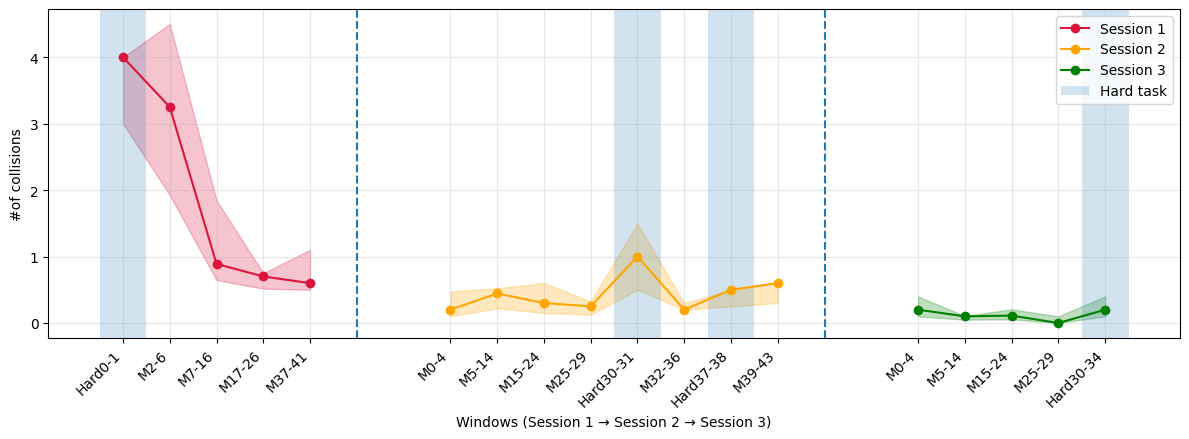

In [59]:
IN_DIR = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group"
GOOD_LABEL = "good"
USE_IQR = True     # True = IQR (Q1-Q3), False = min-max
gap = 2            # how many "window units" between sessions
# =======================

# Windows per session (edit ranges if your trial IDs differ)
WINDOWS_BY_SESSION = {
    1: [
        ("Hard0-1", 0, 1),
        ("M2-6",    2, 6),
        ("M7-16",   7, 16),
        ("M17-26",  17, 26),
        ("M37-41",  37, 41),
    ],
    2: [
        ("M0-4",    0, 4),
        ("M5-14",   5, 14),
        ("M15-24",  15, 24),
        ("M25-29",  25, 29),
        ("Hard30-31", 30, 31),
        ("M32-36",  32, 36),
        ("Hard37-38", 37, 38),
        ("M39-43",  39, 43),
    ],
    3: [
        ("M0-4",    0, 4),
        ("M5-14",   5, 14),
        ("M15-24",  15, 24),
        ("M25-29",  25, 29),
        ("Hard30-34", 30, 34),
    ],
}

def summarize(series, use_iqr=True):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return pd.Series({"median": np.nan, "low": np.nan, "high": np.nan})
    if use_iqr:
        return pd.Series({"median": s.median(), "low": s.quantile(0.25), "high": s.quantile(0.75)})
    else:
        return pd.Series({"median": s.median(), "low": s.min(), "high": s.max()})

def session_window_summary(csv_path, session_num, windows):
    df = pd.read_csv(csv_path)

    # clean
    df["trial"] = pd.to_numeric(df["trial"], errors="coerce")
    df["comment_value"] = pd.to_numeric(df["comment_value"], errors="coerce")
    df["comment_label"] = df["comment_label"].astype(str).str.lower().str.strip()
    df["session"] = pd.to_numeric(df["session"], errors="coerce")

    # keep only this session + good trials
    df = df[(df["session"] == session_num)].dropna(subset=["pid","trial"])
    good = df[(df["comment_label"] == GOOD_LABEL)].dropna(subset=["comment_value"]).copy()

    # per (pid, trial) collision count
    per_trial = (good.groupby(["pid","trial"], as_index=False)
                   .agg(n_collisions=("comment_value","sum")))

    # per participant per window (mean collisions per good trial in that window)
    rows = []
    for wname, a, b in windows:
        tmp = per_trial[per_trial["trial"].between(a, b)]
        per_pid = (tmp.groupby("pid", as_index=False)
                     .agg(coll_per_good_trial=("n_collisions","mean")))
        per_pid["window"] = wname
        rows.append(per_pid)

    win_pid = pd.concat(rows, ignore_index=True)

    # enforce window order
    order = [w[0] for w in windows]
    win_pid["window"] = pd.Categorical(win_pid["window"], categories=order, ordered=True)
    win_pid = win_pid.sort_values(["window","pid"])

    # summarize across participants
    coll_sum = win_pid.groupby("window")["coll_per_good_trial"].apply(lambda s: summarize(s, USE_IQR)).reset_index()
    if "level_1" in coll_sum.columns:
        coll_sum = coll_sum.pivot(index="window", columns="level_1", values="coll_per_good_trial").reset_index()

    coll_sum["window"] = pd.Categorical(coll_sum["window"], categories=order, ordered=True)
    coll_sum = coll_sum.sort_values("window").reset_index(drop=True)

    return coll_sum, order

# ---------- Collect summaries for sessions 1–3 ----------
summaries = []
orders = []
session_nums = [1, 2, 3]

for s in session_nums:
    csv_path = os.path.join(IN_DIR, f"collisions_all_session{s}.csv")
    if not os.path.exists(csv_path):
        print(f"[SKIP] Missing: {csv_path}")
        continue

    coll_sum, order = session_window_summary(csv_path, s, WINDOWS_BY_SESSION[s])
    summaries.append((s, coll_sum))
    orders.append(order)

fig, ax = plt.subplots(figsize=(12, 4.5))
SESSION_COLORS = {
    1: "crimson",   # <- Session 1 color (change to what you like)
    2: "orange",
    3: "green",
}


cursor = 0
boundaries = []
all_xticks, all_xticklabels = [], []
hard_spans = []  # list of (x0, x1, label) spans on the global axis
for (s, coll_sum), order in zip(summaries, orders):
    n = len(order)
    x = np.arange(n) + cursor
    c = SESSION_COLORS.get(s, None)

    med  = coll_sum["median"].astype(float).to_numpy()
    low  = coll_sum["low"].astype(float).to_numpy()
    high = coll_sum["high"].astype(float).to_numpy()

    ax.plot(x, med, marker="o", color=c, label=f"Session {s}")
    ax.fill_between(x, low, high, color=c, alpha=0.25)

    # xticks
    all_xticks.extend(list(x))
    all_xticklabels.extend(order)

    # record hard-window spans (each window occupies [xi-0.5, xi+0.5])
    for i, wname in enumerate(order):
        if "hard" in str(wname).lower():
            xi = x[i]
            hard_spans.append((xi - 0.5, xi + 0.5, wname))

    end = x[-1]
    boundaries.append(end + gap/2)
    cursor = end + 1 + gap

# Shade hard windows
# (label only once so legend isn't duplicated)
hard_labeled = False
for x0, x1, wlab in hard_spans:
    ax.axvspan(x0, x1, alpha=0.2, label=("Hard task" if not hard_labeled else None))
    hard_labeled = True

# session boundary markers
for b in boundaries[:-1]:
    ax.axvline(b, linestyle="--")

ax.set_xticks(all_xticks)
ax.set_xticklabels(all_xticklabels, rotation=45, ha="right")
ax.set_xlabel("Windows (Session 1 → Session 2 → Session 3)")
ax.set_ylabel("#of collisions")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()







In [ ]:
#Session1,2, and 3 merged collision files depending on participant group and session
P1_session1 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251203_SNFH06_Session2"
P2_session1 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251203_SNFH07_Session2"
P3_session1 = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\20251230_SNHF08_Session2"

all_paths = [P1_session1, P2_session1, P3_session1]

def parse_folder_meta(all_events_path: str):
    folder = Path(all_events_path).name

    # pid/session from "..._SNHF06_Session1"
    m = re.search(r"_(?P<pid>[A-Za-z]+[0-9]+)_Session(?P<session>\d+)", folder, re.IGNORECASE)
    if not m:
        raise ValueError(f"Could not parse pid/session from folder name: {folder}")

    pid = m.group("pid")
    print(pid)
    session = int(m.group("session"))

    # optional: date prefix "YYYYMMDD_..."
    date_m = re.match(r"(?P<date>\d{8})_", folder)
    date_str = date_m.group("date") if date_m else None

    return pid, session, date_str, folder

def add_or_overwrite(df, col, value, loc=None):
    """If col exists -> overwrite; else insert at loc (or append)."""
    if col in df.columns:
        df[col] = value
    else:
        if loc is None:
            df[col] = value
        else:
            df.insert(loc, col, value)

all_trialmetrics_dfs = []

for p in all_paths:
    pid, session, date_str, folder = parse_folder_meta(p)

    trialmetricsfiles = glob.glob(os.path.join(p, f"{pid}_Session{session}_trialmetrics.csv"))
    if not trialmetricsfiles:
        trialmetricsfiles = glob.glob(os.path.join(p, "*_trialmetrics.csv"))
    if not trialmetricsfiles:
        print(f"[SKIP] No collision file found in: {p}")
        continue

    cf = trialmetricsfiles[0]
    df = pd.read_csv(cf)

    # add indicators safely
    add_or_overwrite(df, "pid", pid, loc=0)
    add_or_overwrite(df, "session", session, loc=1)   # will overwrite if already present

    all_trialmetrics_dfs.append(df)

trialmetrics_all = pd.concat(all_trialmetrics_dfs, ignore_index=True)
out_path = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group\trialmetrics_all_session3.csv"
trialmetrics_all.to_csv(out_path, index=False)
print("Saved:", out_path)


SNFH06
SNFH07
SNHF08
Saved: D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group\trialmetrics_all_session2.csv


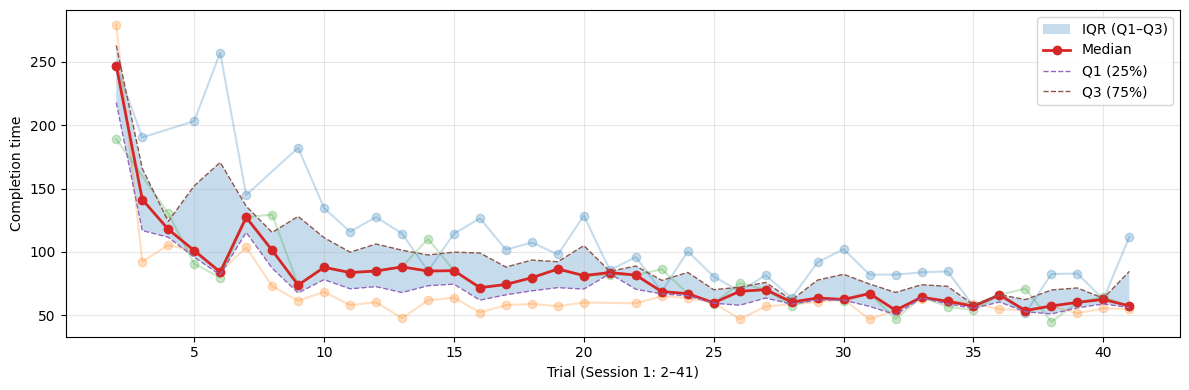

In [71]:
IN_PATH = r"D:\Box Sync\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\1st_Haptic Sleeve\PilotExperiment\MotorLearning\Non-haptic group\trialmetrics_all_session1.csv"

df = pd.read_csv(IN_PATH)

df["trial"] = pd.to_numeric(df["trial"], errors="coerce")
df["completion_time"] = pd.to_numeric(df["completion_time"], errors="coerce")

df = df[(df["session"] == 1) & (df["trial"].between(2, 41))].dropna(subset=["pid","trial","completion_time"])

per_trial = (df.groupby(["pid","trial"], as_index=False)
               .agg(time_duration=("completion_time","mean")))

# ---- Median + quartiles per trial (NaNs ignored) ----
summary = (per_trial.groupby("trial")["time_duration"]
                 .agg(median="median",
                      q1=lambda x: x.quantile(0.25),
                      q3=lambda x: x.quantile(0.75))
                 .reset_index())

# ---- Plot ----
plt.figure(figsize=(12, 4))

# light participant lines (optional, like your figure)
for pid, sub in per_trial.groupby("pid"):
    sub = sub.sort_values("trial")
    plt.plot(sub["trial"], sub["time_duration"], marker="o", alpha=0.25)

# IQR band
plt.fill_between(summary["trial"], summary["q1"], summary["q3"], alpha=0.25, label="IQR (Q1–Q3)")

# median line
plt.plot(summary["trial"], summary["median"], marker="o", linewidth=2, label="Median")

# (optional) show Q1/Q3 as lines too
plt.plot(summary["trial"], summary["q1"], linestyle="--", linewidth=1, label="Q1 (25%)")
plt.plot(summary["trial"], summary["q3"], linestyle="--", linewidth=1, label="Q3 (75%)")

plt.xlabel("Trial (Session 1: 2–41)")
plt.ylabel("Completion time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
